# Panoptic Segmentation Mock-up


Steps:
* Install + load dependencies
* Load test images
* Load pre-trained model
* Run inference on images
* Visualize output
* Extract labels for classified objects

Note: 
>Some of the code was taken from "Detectron2_Tutorial.ipynb". See "Detectron2_Tutorial_sandbox.ipynb" for loading different types of models and viewing different infences, as well as how to fine tune models.

>Original tutorial link(At bottom,lcick Colab Notebooks): https://detectron2.readthedocs.io/tutorials/getting_started.html

In [1]:
# install dependencies: 
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# # install detectron2: (colab has CUDA 10.1 + torch 1.5)
#------ON command, run:------
# pip install pyyaml==5.1 #or => pip3 install pyyaml==5.1
# pip install pycocotools #or => pip3 install pycocotools
# pip install opencv-python #or => pip3 install opencv-python


# Load Dependencies:

In [2]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

1.5.1 False
Configured with: --prefix=/Library/Developer/CommandLineTools/usr --with-gxx-include-dir=/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/c++/4.2.1
Apple clang version 11.0.3 (clang-1103.0.32.62)
Target: x86_64-apple-darwin19.5.0
Thread model: posix
InstalledDir: /Library/Developer/CommandLineTools/usr/bin


In [3]:
assert torch.__version__.startswith("1.5")

In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Load test Images:

In [5]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im1 = cv2.imread("./input.jpg")
im2 = cv2.imread("./beach.jpeg")
im3 = cv2.imread("./bikes.jpeg")

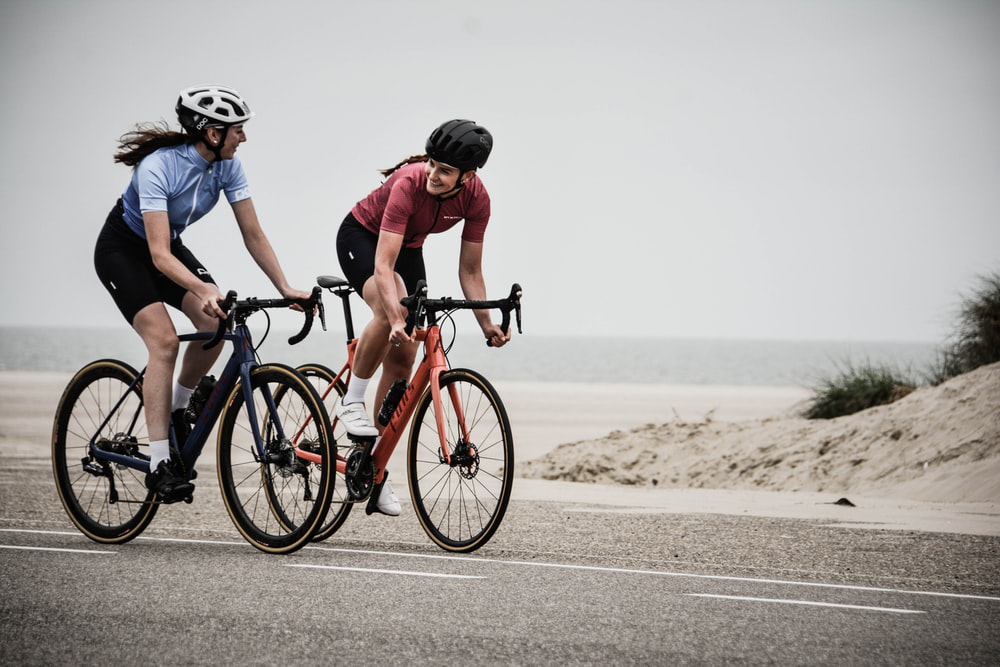

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
# Image.open("./input.jpg")
#Image.open("./beach.jpeg")
Image.open("./bikes.jpeg")

# LOAD PRE-TRAINED MODEL:

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

* Use cfg.MODEL.DEVICE='cpu' only if you don't have a GPU.

In [7]:
# NOTE: See for other models to use -> https://github.com/facebookresearch/detectron2/tree/master/configs

cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))

# Anything inference has to be greater than 50%
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model

# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")

# >>>run line below only if inference will be made on a CPU:
cfg.MODEL.DEVICE='cpu'

#run inference against predictor:
predictor = DefaultPredictor(cfg)

In [8]:
#----another option TO LOAD PRE-TRAINED MODEL---: 
# BUG: ***WARNING*** I think i still need to load the config before makign a prediction
#model = model_zoo.get("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml", trained=True)
# model.eval()
# with torch.no_grad():
#   outputs = model(im)

# Make predictions / inferences to image:

In [9]:
#guy in horse (from tutorial)
outputs1 = predictor(im1)
#beach
outputs2 = predictor(im2)
#girls cycling in beach
outputs3 = predictor(im3)

In [10]:
# look at the outputs:
#  -> NOTE:See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
# print(outputs["instances"].pred_classes)
# print(outputs["instances"].pred_boxes)
# print(outputs["instances"].pred_masks)
print(outputs3["panoptic_seg"][1])
#print(outputs["sem_seg"][:,:])

[{'id': 1, 'isthing': True, 'score': 0.999495267868042, 'category_id': 0, 'instance_id': 0}, {'id': 2, 'isthing': True, 'score': 0.9988834261894226, 'category_id': 0, 'instance_id': 1}, {'id': 3, 'isthing': True, 'score': 0.9974486231803894, 'category_id': 1, 'instance_id': 2}, {'id': 4, 'isthing': True, 'score': 0.9939423203468323, 'category_id': 1, 'instance_id': 3}, {'id': 5, 'isthing': False, 'category_id': 21, 'area': 122946}, {'id': 6, 'isthing': False, 'category_id': 23, 'area': 81396}, {'id': 7, 'isthing': False, 'category_id': 24, 'area': 34879}, {'id': 8, 'isthing': False, 'category_id': 37, 'area': 6769}, {'id': 9, 'isthing': False, 'category_id': 40, 'area': 281030}]


# Visualtize output:

* change any reference of im (options=> im1 | im2 | im3)

* change any reference of outputs (options=> outputs1 | outputs2 | outputs3) to corresponding  im

***WARNING*** After CV opens file on a separate windom, click on image, then press any key to continue, and do not close window if you want to run it again!!

In [11]:
# select image to analyze:
im = im3 # options=> im1 | im2 | im3
outputs = outputs3 #options=> outputs1 | outputs2 | outputs

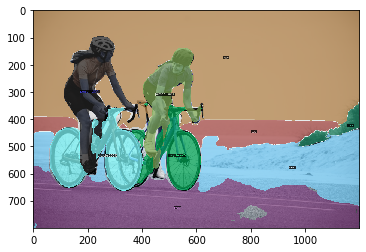

In [12]:
# -------Displays panoptic prediction results on an image-------
# NOTE: https://detectron2.readthedocs.io/modules/utils.html#detectron2.utils.visualizer.Visualizer.draw_panoptic_seg_predictions

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(outputs["panoptic_seg"][0], outputs["panoptic_seg"][1])
#cv2.imshow(out.get_image()[:, :, ::-1])
plt.imshow(out.get_image()[:, :, ::-1]) #small version

#im = cv2.imread(out.get_image()[:, :, ::-1])
cv2.imshow("output", out.get_image()[:, :, ::-1])
cv2.waitKey(0)
cv2.destroyAllWindows()

# Extract labels:

In [21]:
# load classes
thing_classes=['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

stuff_classes=['things', 'banner', 'blanket', 'bridge', 'cardboard', 'counter', 'curtain', 'door-stuff', 'floor-wood', 'flower', 'fruit', 'gravel', 'house', 'light', 'mirror-stuff', 'net', 'pillow', 'platform', 'playingfield', 'railroad', 'river', 'road', 'roof', 'sand', 'sea', 'shelf', 'snow', 'stairs', 'tent', 'towel', 'wall-brick', 'wall-stone', 'wall-tile', 'wall-wood', 'water', 'window-blind', 'window', 'tree', 'fence', 'ceiling', 'sky', 'cabinet', 'table', 'floor', 'pavement', 'mountain', 'grass', 'dirt', 'paper', 'food', 'building', 'rock', 'wall', 'rug']

print("Total number of posible classes: " + str(len(stuff_classes) + len(thing_classes)))

Total number of posible classes: 134


In [14]:
#Get class ID (category_id) and the class it belongs to (bool)
classID = list()
for i in range(len(outputs["panoptic_seg"][1])):
    
    classID.append([outputs["panoptic_seg"][1][i]['category_id'], outputs["panoptic_seg"][1][i]['isthing']])
    print(outputs["panoptic_seg"][1][i])

print("")
print(classID)
print("")

{'id': 1, 'isthing': True, 'score': 0.999495267868042, 'category_id': 0, 'instance_id': 0, 'area': 34638.0}
{'id': 2, 'isthing': True, 'score': 0.9988834261894226, 'category_id': 0, 'instance_id': 1, 'area': 26726.0}
{'id': 3, 'isthing': True, 'score': 0.9974486231803894, 'category_id': 1, 'instance_id': 2, 'area': 38370.0}
{'id': 4, 'isthing': True, 'score': 0.9939423203468323, 'category_id': 1, 'instance_id': 3, 'area': 23873.0}
{'id': 5, 'isthing': False, 'category_id': 21, 'area': 122946.0}
{'id': 6, 'isthing': False, 'category_id': 23, 'area': 81396.0}
{'id': 7, 'isthing': False, 'category_id': 24, 'area': 34879.0}
{'id': 8, 'isthing': False, 'category_id': 37, 'area': 6769.0}
{'id': 9, 'isthing': False, 'category_id': 40, 'area': 281030.0}

[[0, True], [0, True], [1, True], [1, True], [21, False], [23, False], [24, False], [37, False], [40, False]]



In [15]:
# display labels extracted
# TODO: Labels might need to be a dictionary to be the corresponding value of an imageID key
labels = list()
for i in range(len(classID)):
    if classID[i][1] == True:
        print(thing_classes[classID[i][0]])
        labels.append(thing_classes[classID[i][0]])
    else:
        print(stuff_classes[classID[i][0]])
        labels.append(stuff_classes[classID[i][0]])

person
person
bicycle
bicycle
road
sand
sea
tree
sky


In [16]:
print(labels)

['person', 'person', 'bicycle', 'bicycle', 'road', 'sand', 'sea', 'tree', 'sky']
